# RESOLUCIÓN DEL PROBLEMA INVERSO

En este notebook que se procederá a la resolución de problema ibversión y a la posterior obtención de medidas de conectividad a partir de los resultados obtenidos. Primeramente, se explicará paso a paso el procedimiento con un elemento de muestra y posteriormente se deberá iterar sobre el conjunto de datos realizando estas operaciones en cada elemento

## Importación de librerías necesarias y elección de dispositivo

In [1]:
import pickle
import torch
import os
import os.path as op
import mne
import numpy as np
import matplotlib.pyplot as plt
import json
from mne.datasets import eegbci
from mne.datasets import fetch_fsaverage
from mne.coreg import Coregistration
from mne.io.constants import FIFF
from mne.coreg import estimate_head_mri_t
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne_connectivity.viz import plot_connectivity_circle
from sklearn.decomposition import PCA

# Durante el desarrollo del proyecto se utilizaó la GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Importación de dataloaders y creación de elemento de muestra

In [2]:
train_loader_file = r'../dataloaders/mean_std_train'
val_loader_file = r'../dataloaders/mean_std_val.pkl'

with open(train_loader_file, 'rb') as file:
    dataloader_train = pickle.load(file)
    
with open(val_loader_file, 'rb') as file:
    dataloader_val = pickle.load(file)

for batch in dataloader_train:
    sample = batch
    break

## Creación de epochs

Creating RawArray with float64 data, n_channels=19, n_times=2000
    Range : 0 ... 1999 =      0.000 ...     9.995 secs
Ready.
[[  0   0   1]
 [  0   0   2]
 [  9   0  47]
 [ 17   0  48]
 [ 47   0  47]
 [ 54   0  48]
 [ 85   0  47]
 [ 92   0  48]
 [122   0  47]
 [127   0  48]
 [158   0  47]
 [163   0  48]
 [224   0  47]
 [229   0  48]
 [286   0  47]
 [292   0  48]
 [345   0  17]
 [347   0  47]
 [353   0  48]
 [355   0  44]
 [365   0  21]
 [376   0  44]
 [379   0  47]
 [382   0  48]
 [386   0  25]
 [396   0  44]
 [406   0  27]
 [416   0  44]
 [426   0  29]
 [436   0  44]
 [439   0  47]
 [443   0  48]
 [447   0  33]
 [457   0  44]
 [467   0  35]
 [477   0  44]
 [487   0  37]
 [497   0  44]
 [508   0  39]
 [518   0  44]
 [519   0  47]
 [523   0  48]
 [528   0  43]
 [538   0  44]
 [581   0  47]
 [587   0  48]
 [701   0  47]
 [705   0  48]
 [851   0  49]]
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
48 matc

C:\Users\hernandez\AppData\Local\Temp\ipykernel_16224\2811845316.py:29: RuntimeWarning: Not setting positions of 19 misc channels found in montage:
['Fp1', 'F3', 'C3', 'P3', 'O1', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F7', 'T3', 'T5', 'F8', 'T4', 'T6', 'Fz', 'Cz', 'Pz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


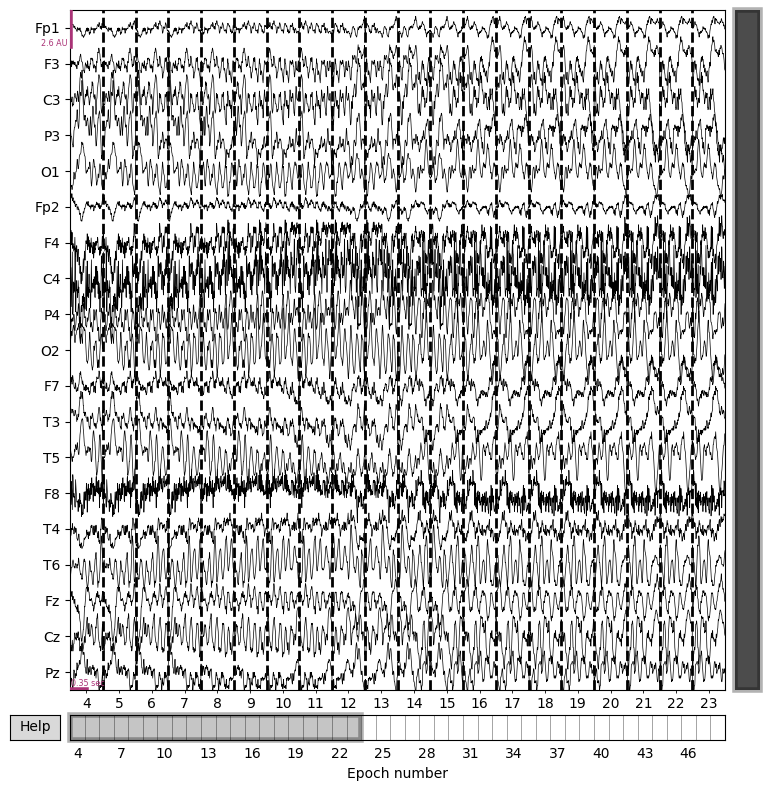

In [8]:
data_path = r'C:\Users\hernandez\Documents\TFG\caueeg-dataset'

anno_path = os.path.join(data_path, 'annotation.json')
with open(anno_path, 'r') as json_file:
    annotation = json.load(json_file)

#Filtro de canales y renombramiento para poder hacer el montaje 10-20
signal_headers = annotation['signal_header']
channel_ekg = signal_headers.index('EKG')
channel_photic = signal_headers.index('Photic')
new_channel_names = [name.replace('-AVG', '') for name in signal_headers]
new_channel_names = [name.replace('Z', 'z') if name.endswith('Z') else name for name in new_channel_names]




raw_data = sample['signal'].squeeze().cpu()  # Eliminar dimensiones adicionales
n_channels = raw_data.shape[0]
ch_names = [new_channel_names[i] for i in range(n_channels)]
sfreq = 200
info = mne.create_info(ch_names=ch_names, sfreq=sfreq)

# Crear el objeto RawArray con los datos procesados
raw = mne.io.RawArray(raw_data, info)
info = raw.info

# Montaje electrodos 10-20
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)


# Creación de nuevo diccionario de tiempos y tipos y generación de eventos
events = np.array(sample['event'][0])
unique_events = np.unique(events, axis=0)
event_names = [str(event[1]) for event in unique_events[0]]
event_id = {event_name: i + 1 for i, event_name in enumerate(event_names)}

event_times = events[0, :, 0].astype(float) / sfreq
event_ids = np.array([event_id[event_name] for event_name in events[0, :, 1]], dtype=np.int64)

# Asegurar que los arrays tienen la misma longitud
min_length = min(len(event_times), len(event_ids))
event_times = event_times[:min_length]
event_ids = event_ids[:min_length]

# Concatenar los arrays
mne_events = np.column_stack((event_times, np.zeros(min_length, dtype=np.int64), event_ids))
events = np.array(mne_events, dtype=np.int32)
print(events)

tmin = -0.2
tmax = 0.5
baseline = (-0.2, 0)

# Crear los epochs
epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax,
                    baseline=baseline, event_repeated='merge', preload=True)

plt.ion()
fig = mne.viz.plot_epochs(epochs, picks='all')
plt.show()

## Importación e instancia de los modelos usados de fsaverage

In [3]:
#Ruta donde están guardados los modelos
fs_dir = mne.datasets.fetch_fsaverage(subjects_dir='subjects_dir', verbose=True)

#Uso de "fsaverage", modelo de cerebro promedio construido a partir de múltiples escaneos de RM
subject = 'fsaverage'
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

#Uso de la técnica BEM para la estimación y modelado de la distriución de la actividad cerebral
fname_src = op.join(fs_dir, "bem", "fsaverage-ico-5-src.fif")

# Creación de la fuente
src = mne.read_source_spaces(fname_src)

bem = op.join(fs_dir, "bem", "fsaverage-5120-5120-5120-bem-sol.fif")
fname_aseg = op.join(subjects_dir, subject, 'mri', 'aseg.mgz')

##  Configuración del espacio de fuentes volumétricas

In [14]:
vol_src = mne.setup_volume_source_space(
    subject,
    mri=fname_aseg,
    pos=30.0,
    bem=bem,
    subjects_dir=subjects_dir,
    add_interpolator=True,
    verbose=True,
)
src += vol_src

BEM              : C:\Users\hernandez\Documents\TFG\subjects_dir\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
grid                  : 30.0 mm
mindist               : 5.0 mm
MRI volume            : C:\Users\hernandez\Documents\TFG\subjects_dir\fsaverage\mri\aseg.mgz

Reading C:\Users\hernandez\Documents\TFG\subjects_dir\fsaverage\mri\aseg.mgz...

Loaded inner skull from C:\Users\hernandez\Documents\TFG\subjects_dir\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif (2562 nodes)
Surface CM = (  -0.5  -21.1    6.2) mm
Surface fits inside a sphere with radius   98.3 mm
Surface extent:
    x =  -75.2 ...   76.3 mm
    y = -113.3 ...   75.0 mm
    z =  -71.7 ...   88.2 mm
Grid extent:
    x =  -90.0 ...   90.0 mm
    y = -120.0 ...   90.0 mm
    z =  -90.0 ...   90.0 mm
392 sources before omitting any.
148 sources after omitting infeasible sources not within 0.0 - 98.3 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    32874506/16777216 nonzero values for the whole brain
[done]


In [15]:
print(
    f"El espacio fuente contiene {len(src)} espacios y "
    f"{sum(s['nuse'] for s in src)} vértices"
)

El espacio fuente contiene 3 espacios y 20561 vértices


## Visualización 3D del modelo cerebral creado

In [16]:
src.plot(subjects_dir=subjects_dir)

Using pyvistaqt 3d backend.

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle



## Adapctación del modelo cerebral a los puntos anatómicos del paciente

In [17]:
info = raw.info

#Extracción de los puntos fiduciales específicos del paciente mustra para la personalización del modeo generado
lpa = raw.info['dig'][0]['r'] / 1000.0  # Convertir de mm a m
nasion = raw.info['dig'][1]['r'] / 1000.0  # Convertir de mm a m
rpa = raw.info['dig'][2]['r'] / 1000.0  # Convertir de mm a m

# "Corregistration": alineamiento de los datos de la imagen de RM con los datos del paciente de señales EEG
coreg = Coregistration(info=raw.info, subject='fsaverage', subjects_dir=subjects_dir, fiducials={'lpa': lpa, 'nasion': nasion, 'rpa': rpa})
coreg.fit_fiducials()

# Transformación:captura la relación espacial y la alineación entre los sistemas de coordenadas de la cabeza e imagen MRI
trans = coreg.trans

# Se calcula el promedio de las épocas (epochs)
evoked = epochs.average(picks='all')

evoked_info = evoked.info

#Cambio etiquetado a EEG
for ch_name in evoked_info['ch_names']:
    evoked_info['chs'][evoked_info['ch_names'].index(ch_name)]['kind'] = FIFF.FIFFV_EEG_CH

#Aplicación montaje 10-20
montage = mne.channels.make_standard_montage('standard_1020')
evoked_info.set_montage(montage)

# Resolución del problema directo (forward), necesario para la resolución del problema inverso. Calcula la actividad eléctrica generada en los canales EEG
fwd = mne.make_forward_solution(
    evoked_info,
    trans=trans,
    src=src,
    bem=bem,
    mindist=5.0,
    meg=False,
    eeg=True,
    n_jobs=1
)

del src  # liberar memoria

leadfield = fwd["sol"]["data"]
print("Tamaño de campo : %d sensores x %d dipolos" % leadfield.shape)
print(
    f"El espacio fuente fwd contiene {len(fwd['src'])} espacios y "
    f"{sum(s['nuse'] for s in fwd['src'])} vértices"
)

Using high resolution head model in C:\Users\hernandez\Documents\TFG\subjects_dir\fsaverage\bem\fsaverage-head-dense.fif
    Triangle neighbors and vertex normals...
Aligning using fiducials
Start median distance:   1.18 mm
End   median distance:  15.15 mm
Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=10242>, <surface (rh), n_vertices=163842, n_used=10242>, <volume, shape=(7, 8, 7), n_used=77>] MRI (surface RAS) coords, subject 'fsaverage', ~85.9 MB>
MRI -> head transform : instance of Transform
Measurement data      : instance of Info
Conductor model   : C:\Users\hernandez\Documents\TFG\subjects_dir\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 3 source spaces a total of 20561 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000      94.94 mm
    

## Cálculo de la covarianza

In [19]:
#Se establece una referencia promedio
evoked.set_eeg_reference(ref_channels='average', projection=True)

data = evoked.data
ch_names = evoked.ch_names
sfreq = evoked.info['sfreq']
bads = evoked.info['bads']
projs = evoked.info['projs']
nfree = data.shape[0] - len(projs)

info_cov = mne.create_info(ch_names, sfreq, ch_types='eeg')

#Se crean las epochs
epochs = mne.EpochsArray(data[np.newaxis], info=info_cov)
cov = mne.compute_covariance(epochs, projs=projs, method='auto')

EEG channel type selected for re-referencing
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Computing rank from data with rank=None
    Using tolerance 1.3e-07 (2.2e-16 eps * 19 dim * 3.1e+07  max singular value)
    Estimated rank (eeg): 19
    EEG: rank 19 computed from 19 data channels with 0 projectors
Reducing data rank from 19 -> 19
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 141
log-likelihood on unseen data (descending order):
   shrunk: -246.958
   diagonal_fixed: -255.470
   empirical: -322.846
selecting best estimator: shrunk
[done]


C:\Users\hernandez\AppData\Local\Temp\ipykernel_16224\1221535392.py:2: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference(ref_channels='average', projection=True)
C:\Users\hernandez\AppData\Local\Temp\ipykernel_16224\1221535392.py:15: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs, projs=projs, method='auto')


## Generación del espacio fuente

In [20]:
snr = 2.0 #Especificación de la relación señal-ruido
inv_method = "dSPM" # Definición del método de inversión (método de mínimos cuadrados ponderados de fuente distribuida)
parc = "aparc" # Parcela a utilizar
loose = dict(surface=0.2, volume=1.0) # Especificación de parámetros de la inversión

lambda2 = 1.0 / snr**2 # valor parámetro de regularización

# Creación del operador inverso a partir de la solución directa
inverse_operator = make_inverse_operator(
    evoked.info, fwd, cov, depth=None, loose=loose, verbose=True
)
del fwd # Liberar memoria

# Aplicación del operador inverso a las épocas promediadas para obtención de la estimación de la actividad cerebral en una serie temporal de las fuentes espaciales
stc = apply_inverse(evoked, inverse_operator, lambda2, inv_method, pick_ori=None)
#Se genera un espacio
src = inverse_operator["src"]

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 19 channels.
    19 out of 19 channels remain after picking
Selected 19 channels
Applying loose dipole orientations to surface source spaces: 0.2
Applying free  dipole orientations to volume  source spaces: 1.0
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 0.00028 (2.2e-16 eps * 19 dim * 6.6e+10  max singular value)
    Estimated rank (eeg): 18
    EEG: rank 18 computed from 19 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest s

## Visualización y cálculo del vector

In [21]:
initial_time = 0.1
# Se calcula el vector con la estimación de la actividad cerebral en cada fuente
stc_vec = apply_inverse(
    evoked, inverse_operator, lambda2, inv_method, pick_ori="vector"
)
#Se visualiza en 3D el resultado
brain = stc_vec.plot(
    hemi="both",
    src=inverse_operator["src"],
    views="coronal",
    initial_time=initial_time,
    subjects_dir=subjects_dir,
    brain_kwargs=dict(silhouette=True),
    smoothing_steps=7,
)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 45
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 18 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "0.27 × Eyes Open + 0.27 × Eyes Closed + 0.02 × Photic On - 3.0 Hz + 0.22 × Photic Off + 0.02 × Photic On - 6.0 Hz + 0.02 × Photic On - 9.0 Hz + 0.02 × Photic On - 12.0 Hz + 0.02 × Photic On - 15.0 Hz + 0.02 × Photic On - 18.0 Hz + 0.02 × Photic On - 21.0 Hz + 0.02 × Photic On - 24.0 Hz + 0.02 × Photic On - 27.0 Hz + 0.02 × Photic On - 30.0 Hz + 0.02 × Paused + 0.00 × New Montage - Montage 002/Start Recording"...
    Picked 19 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  49.4% variance
    dSPM...
[done]
Using control points 

# CREACIÓN DE MEDIDAS DE CONECTIVIDAD

## Análisis PCA

In [25]:
reshaped_data = stc_vec.data.reshape(-1, stc_vec.data.shape[-1])

k = 30
# realización de análisis PCA para la reducción de los datos
pca = PCA(n_components=k)
pca.fit(reshaped_data)

principal_components = pca.components_  # Matriz de los componentes principales
transformed_data = pca.transform(reshaped_data) 

## Análisis de conectividad funcional

In [26]:
# Leer las etiquetas del archivo de anotación
labels = mne.read_labels_from_annot('fsaverage', 'aparc')

# Serelcción de regiones relevantes
region_labels = ['entorhinal-lh', 'entorhinal-rh', 'inferiorparietal-lh', 'inferiorparietal-rh',
                 'inferiortemporal-lh', 'inferiortemporal-rh', 'medialorbitofrontal-lh',
                 'medialorbitofrontal-rh', 'parahippocampal-lh', 'parahippocampal-rh',
                 'posteriorcingulate-lh', 'posteriorcingulate-rh', 'precuneus-lh', 'precuneus-rh',
                 'superiorfrontal-lh', 'superiorfrontal-rh', 'superiortemporal-lh', 'superiortemporal-rh',
                 'supramarginal-lh', 'supramarginal-rh']

label_indices = {label.name: idx for idx, label in enumerate(labels)}

region_indices = [label_indices[label] for label in region_labels if label in label_indices]

# Generación de matriz para agrupar los datos
grouped_data = np.zeros((len(region_indices), stc_vec.data.shape[1], stc_vec.data.shape[2])) 

#Cálculo de la media de la actividad de todos los vértices en cada una de las regiones seleccionadas
for region_idx, region_label in enumerate(region_labels):
    if region_label in label_indices:
        region_vertices = labels[label_indices[region_label]].vertices
        vertices_indices = np.where(np.isin(stc_vec.vertices[0], region_vertices))[0] 
        region_data = stc_vec.data[vertices_indices, :, :]  
        region_mean = np.mean(region_data, axis=0)
        grouped_data[region_idx] = region_mean

n_regions = len(region_indices)
n_times = grouped_data.shape[1]
n_freqs = grouped_data.shape[2]
coherence_matrix = np.zeros((n_regions, n_regions, n_freqs))

#Cálculo de la coherencia entre las regiones por correlación de Pearson
for i in range(n_regions):
    for j in range(n_regions):
        region_i_data = grouped_data[i]
        region_j_data = grouped_data[j]
        for freq_idx in range(n_freqs):
            region_i_time_series = region_i_data[:, freq_idx]
            region_j_time_series = region_j_data[:, freq_idx]
            coherence = np.corrcoef(region_i_time_series, region_j_time_series)[0, 1]
            coherence_matrix[i, j, freq_idx] = coherence

Reading labels from parcellation...
   read 35 labels from C:\Users\hernandez\Documents\TFG\subjects_dir\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\hernandez\Documents\TFG\subjects_dir\fsaverage\label\rh.aparc.annot


## Visualización de la conectividad entre las distintas regiones

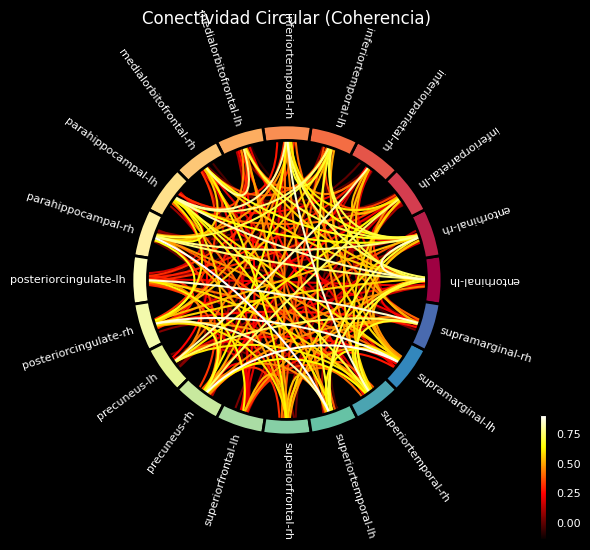

In [27]:
# Cálculo de los promedios de las coherencias
conmat = np.mean(coherence_matrix, axis=2)
fig, ax = plt.subplots(figsize=(8, 8), facecolor='black', subplot_kw=dict(polar=True))
plot_connectivity_circle(conmat, region_labels, n_lines=300,
                         title='Conectividad Circular (Coherencia)', ax=ax)
plt.show()


## Secuencias temporales de actividad cerebral

In [28]:
# Cálculo de vértices en cada región de interés
region_vertices = []
region_labels_filtered = []
for label in labels:
    if label.name in region_labels:
        region_labels_filtered.append(label)
        vertices_in_label = label.vertices
        region_vertices.extend(vertices_in_label)
region_vertices = np.unique(region_vertices)


In [29]:
#Cálculo de series temporales en las regiones de interés
label_ts = []
for label in region_labels_filtered:
    ts = mne.source_estimate.extract_label_time_course(stc_vec, label, src, mode='mean')
    label_ts.append(ts)

Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)
Extracting time courses for 2 labels (mode: mean)


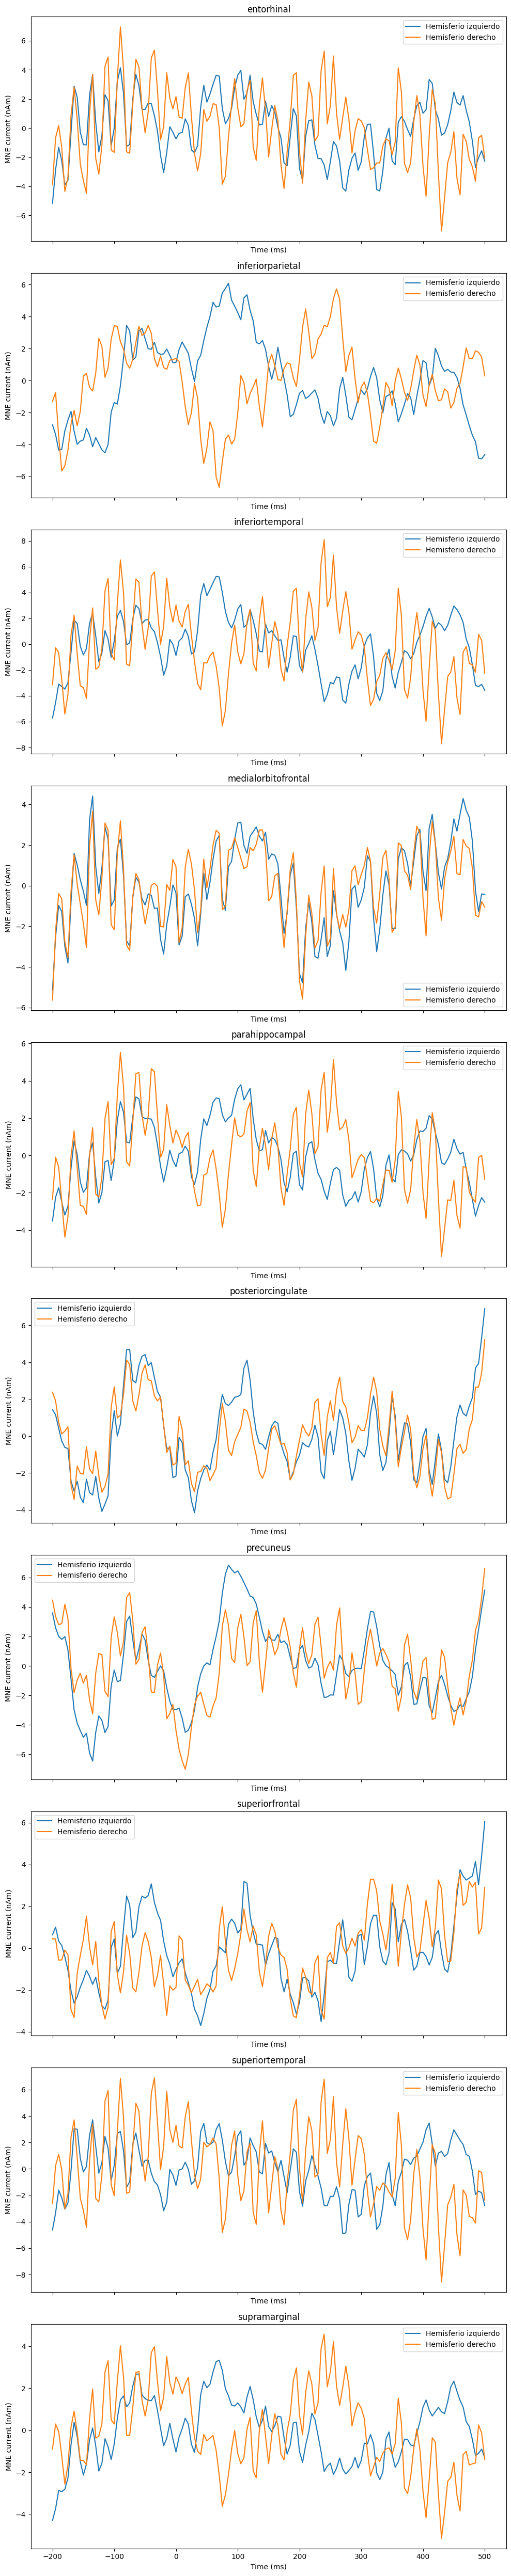

In [33]:
num_labels = len(region_labels) // 2  # Dividir por 2 para tener la mitad de gráficas
fig, axes = plt.subplots(num_labels, 1, figsize=(10, 5*num_labels), sharex=True)

# Visualización de la actividad cerebral en cada hemisferio de las regiones escogidas de interés
for i in range(num_labels):
    label_mat_left = label_ts[2*i][0][0]
    label_mat_right = label_ts[2*i+1][0][0]

    times = stc.times[:label_mat_left.shape[0]]
    ax = axes[i]
    ax.plot(1e3 * times, label_mat_left, label='Hemisferio izquierdo')
    ax.plot(1e3 * times, label_mat_right, label='Hemisferio derecho')

    ax.set_title(region_labels[2*i].split('-')[0]) 
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('MNE current (nAm)')

    ax.legend()

plt.tight_layout()

plt.show()


### Cálculo de nuevas medidas de conectividad a partir de las secuencias temporales

In [34]:
label_ts_array = np.array(label_ts)

n_regions, _, _, n_times = label_ts_array.shape
coherence_matrix = np.zeros((n_regions, n_regions))

#Cálculo de matriz de coherencia entre las distintas regiones
for i in range(n_regions):
    for j in range(n_regions):
        corr_coef = np.corrcoef(label_ts_array[i, :, :, :].flatten(), label_ts_array[j, :, :, :].flatten())[0, 1]
        coherence_matrix[i, j] = corr_coef

In [35]:
# reducción de la matriz por análisis PCA
pca = PCA(n_components=10)
reduced_matrix = pca.fit_transform(coherence_matrix)